In [1]:
import matplotlib.pyplot as plt
import os
import datetime
import numpy as np

In [2]:
def extract_train_data(file_path):
    epochs = []
    losses = []
    accuracies = []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        for line in lines:
            if 'Epoch' in line:
                epoch = int(line.split('[')[1].split(']')[0])
                epochs.append(epoch)
                
                loss = float(line.split('Loss ')[1].split('\t')[0])
                losses.append(loss)
                
                accuracy = float(line.split('Acc@1 ')[1].split('\n')[0].split('\t')[0])
                accuracies.append(accuracy)
    
    return epochs, losses, accuracies

In [3]:
def extract_test_data(file_path):
    epochs = []
    losses = []
    accuracies = []
    ep = 0
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        for line in lines:
            if 'Test' in line:
                line_data = line.split('Loss')
                
                epochs.append(ep)
                ep += 1
                
                loss = float(line_data[1].split('\t')[0])
                losses.append(loss)
                
                accuracy = float(line_data[1].split()[2])
                accuracies.append(accuracy)
                
    return epochs, losses, accuracies

In [4]:
def extract_memory_data(file_path):
    pid_list = []
    gpu_uuid_list = []
    memory_list = []

    with open(file_path, 'r') as file:
        for line in file:
            fields = line.split(',')
            
            if len(fields) == 2:
                pid = fields[0]
                memory = fields[1].split()[0]
                gpu_uuid = None
            elif len(fields) == 3:
                pid = fields[0]
                gpu_uuid = fields[1].strip()
                memory = fields[2].split()[0]
            else:
                continue

            try:
                pid = int(pid)
                memory = int(memory)
            except ValueError:
                continue

            pid_list.append(pid)
            gpu_uuid_list.append(gpu_uuid)
            memory_list.append(memory)

    return pid_list, gpu_uuid_list, memory_list

In [5]:
def extract_runtime(file_path):
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
        first_line = lines[0]
        first_time_str = first_line.split(',')[0]
        first_time = datetime.datetime.strptime(first_time_str, "%Y-%m-%d %H:%M:%S")
    
        last_line = lines[-1]
        last_time_str = last_line.split(',')[0]
        last_time = datetime.datetime.strptime(last_time_str, "%Y-%m-%d %H:%M:%S")
    
    runtime = last_time - first_time

    hours = runtime.seconds // 3600
    minutes = (runtime.seconds // 60) % 60
    seconds = runtime.seconds % 60

    return hours, minutes, seconds

### Primer experimento: mdeq_LARGE vs ResNet-18 en CIFAR

In [6]:
current_dir = os.getcwd()
file_path1 = os.path.join(current_dir, 'deq', 'output', 'mdeq_LARGE-cifar_train.log')
epochs1_train, losses1_train, accuracies1_train = extract_train_data(file_path1)
# como hay varias tomas dentro de una misma época, hacemos la media
indexes = [i for i,x in enumerate(epochs1_train) if i == 0 or x != epochs1_train[i-1]] + [len(epochs1_train)-1]
epochs1_train = list(set(epochs1_train))
losses1_train = [sum(losses1_train[indexes[i]:indexes[i+1]]) / len(losses1_train[indexes[i]:indexes[i+1]]) for i in range(len(indexes)-1)]
accuracies1_train = [sum(accuracies1_train[indexes[i]:indexes[i+1]]) / len(accuracies1_train[indexes[i]:indexes[i+1]]) for i in range(len(indexes)-1)]
epochs1_test, losses1_test, accuracies1_test = extract_test_data(file_path1)
runtime1 = extract_runtime(file_path1)
file_path1 = os.path.join(current_dir, 'deq', 'memory_usage', 'mdeq_LARGE-cifar_memory.txt')
_, _, consumption1 = extract_memory_data(file_path1)
print('-- mdeq_LARGE-cifar --')
print(' Precisión en test:', accuracies1_test[-1])
print(' Mejor precisión en test:', max(accuracies1_test), 'en época:', np.argmax(accuracies1_test))
print(' Épocas:', max(epochs1_train)+1)
print(' Tiempo de ejecución:', runtime1[0], 'horas,', runtime1[1], 'minutos,', runtime1[2], 'segundos')
print(' Consumo GPU medio (MB): {:.2f}'.format(sum(consumption1) / len(consumption1)))
print('----')

-- mdeq_LARGE-cifar --
 Precisión en test: 92.3
 Mejor precisión en test: 92.5 en época: 212
 Épocas: 220
 Tiempo de ejecución: 9 horas, 0 minutos, 48 segundos
 Consumo GPU medio (MB): 2138.91
----


In [7]:
file_path2 = os.path.join(current_dir, 'explicitos', 'output', 'resnet18-cifar_train.log')
epochs2_train, losses2_train, accuracies2_train = extract_train_data(file_path2)
# como hay varias tomas dentro de una misma época, hacemos la media
indexes = [i for i,x in enumerate(epochs2_train) if i == 0 or x != epochs2_train[i-1]] + [len(epochs2_train)-1]
epochs2_train = list(set(epochs2_train))
losses2_train = [sum(losses2_train[indexes[i]:indexes[i+1]]) / len(losses2_train[indexes[i]:indexes[i+1]]) for i in range(len(indexes)-1)]
accuracies2_train = [sum(accuracies2_train[indexes[i]:indexes[i+1]]) / len(accuracies2_train[indexes[i]:indexes[i+1]]) for i in range(len(indexes)-1)]
epochs2_test, losses2_test, accuracies2_test = extract_test_data(file_path2)
runtime2 = extract_runtime(file_path2)
file_path2 = os.path.join(current_dir, 'explicitos', 'memory_usage', 'resnet18-cifar_memory.txt')
_, _, consumption2 = extract_memory_data(file_path2)
print('-- resnet18-cifar --')
print(' Precisión en test (%):', accuracies2_test[-1])
print(' Mejor precisión en test (%):', max(accuracies2_test), 'en época:', np.argmax(accuracies2_test))
print(' Épocas:', max(epochs2_train)+1)
print(' Tiempo de ejecución:', runtime2[0], 'horas,', runtime2[1], 'minutos,', runtime2[2], 'segundos')
print(' Consumo GPU medio (MB): {:.2f}'.format(sum(consumption2) / len(consumption2)))
print('----')

-- resnet18-cifar --
 Precisión en test (%): 86.82
 Mejor precisión en test (%): 87.01 en época: 185
 Épocas: 220
 Tiempo de ejecución: 0 horas, 47 minutos, 26 segundos
 Consumo GPU medio (MB): 1705.33
----


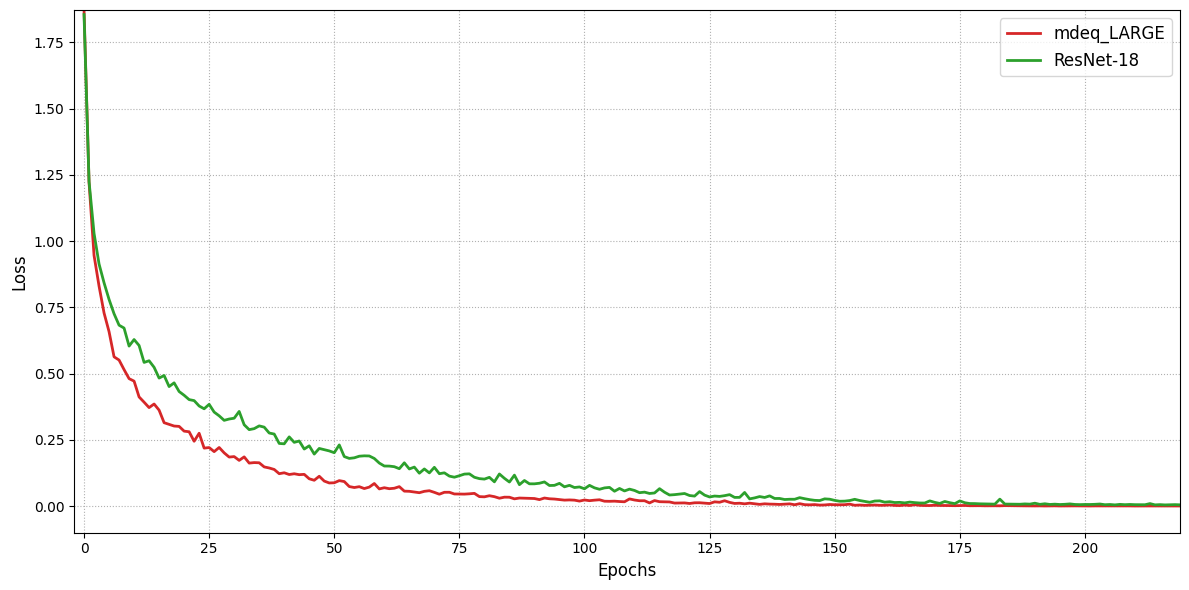

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(epochs1_train, losses1_train, label='mdeq_LARGE', linewidth=2, color='tab:red')
plt.plot(epochs2_train, losses2_train, label='ResNet-18', linewidth=2, color='tab:green')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
#plt.title('Evolución de la pérdida en train', fontsize=16)
plt.xlim(-2, max(max(epochs1_train), max(epochs2_train)))
plt.ylim(-0.1, max(max(losses1_train), max(losses2_train)))
plt.legend(loc='upper right', fontsize=12)
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('figuras/primero-perdida-en-train.png')
plt.show()

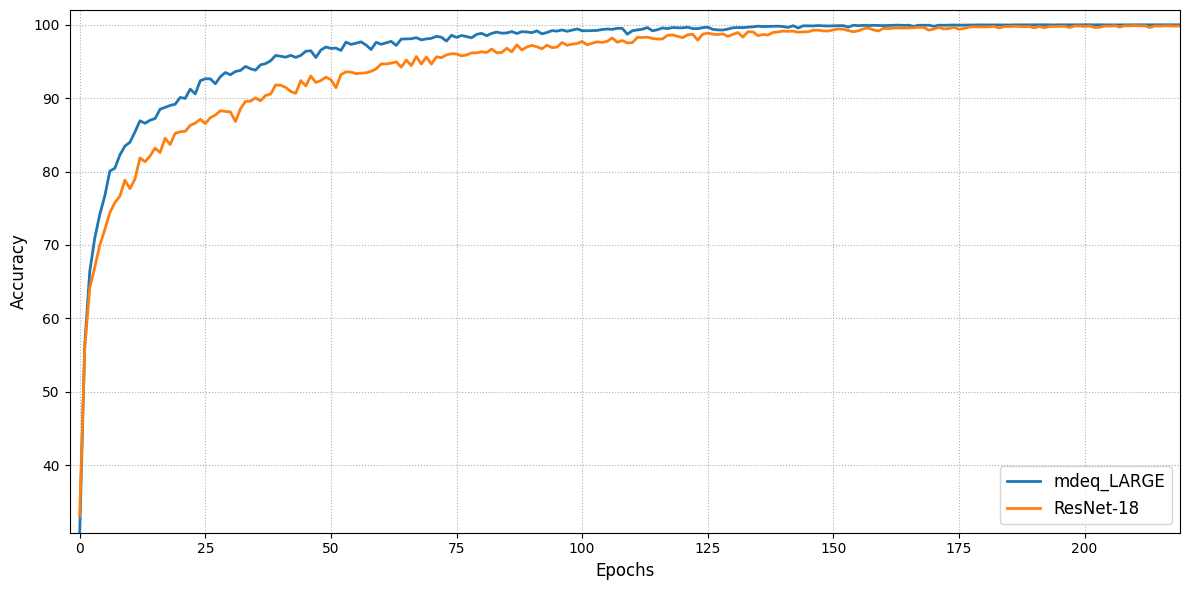

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(epochs1_train, accuracies1_train, label='mdeq_LARGE', linewidth=2, color='tab:blue')
plt.plot(epochs2_train, accuracies2_train, label='ResNet-18', linewidth=2, color='tab:orange')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
#plt.title('Evolución de la precisión en train', fontsize=16)
plt.xlim(-2, max(max(epochs1_train), max(epochs2_train)))
plt.ylim(min(min(accuracies1_train), min(accuracies2_train)), 102)
plt.legend(loc='lower right', fontsize=12)
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('figuras/primero-precision-en-train.png')
plt.show()

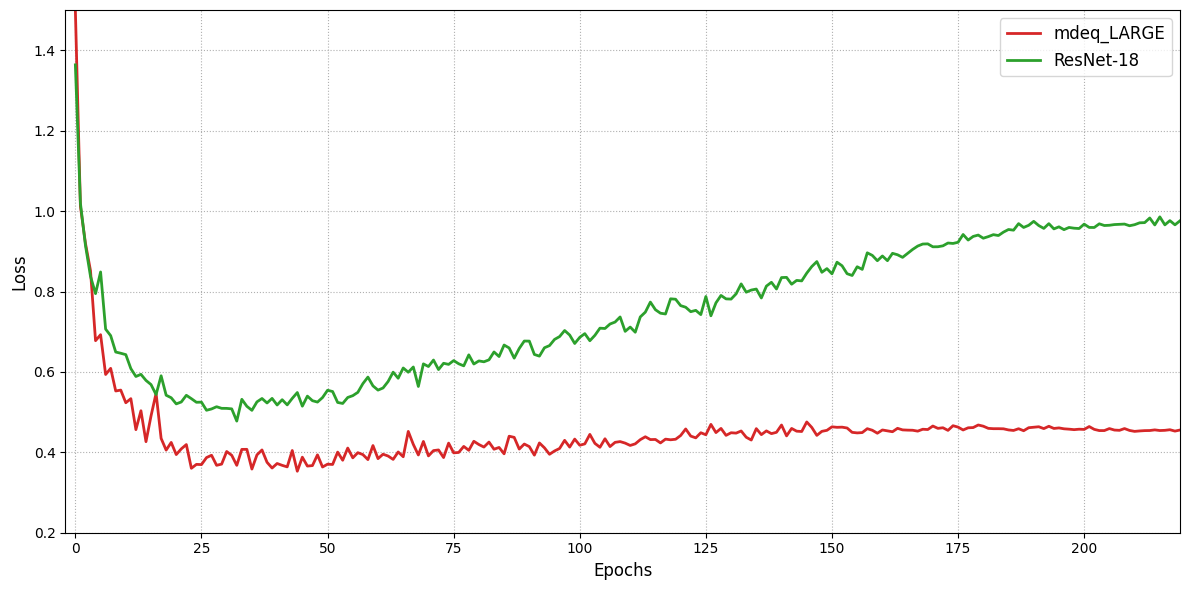

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(epochs1_test, losses1_test, label='mdeq_LARGE', linewidth=2, color='tab:red')
plt.plot(epochs2_test, losses2_test, label='ResNet-18', linewidth=2, color='tab:green')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
#plt.title('Evolución de la pérdida en test', fontsize=16)
plt.xlim(-2, max(max(epochs1_test), max(epochs2_test)))
plt.ylim(0.2, max(max(losses1_test), max(losses2_test)))
plt.legend(loc='upper right', fontsize=12)
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('figuras/primero-perdida-en-test.png')
plt.show()

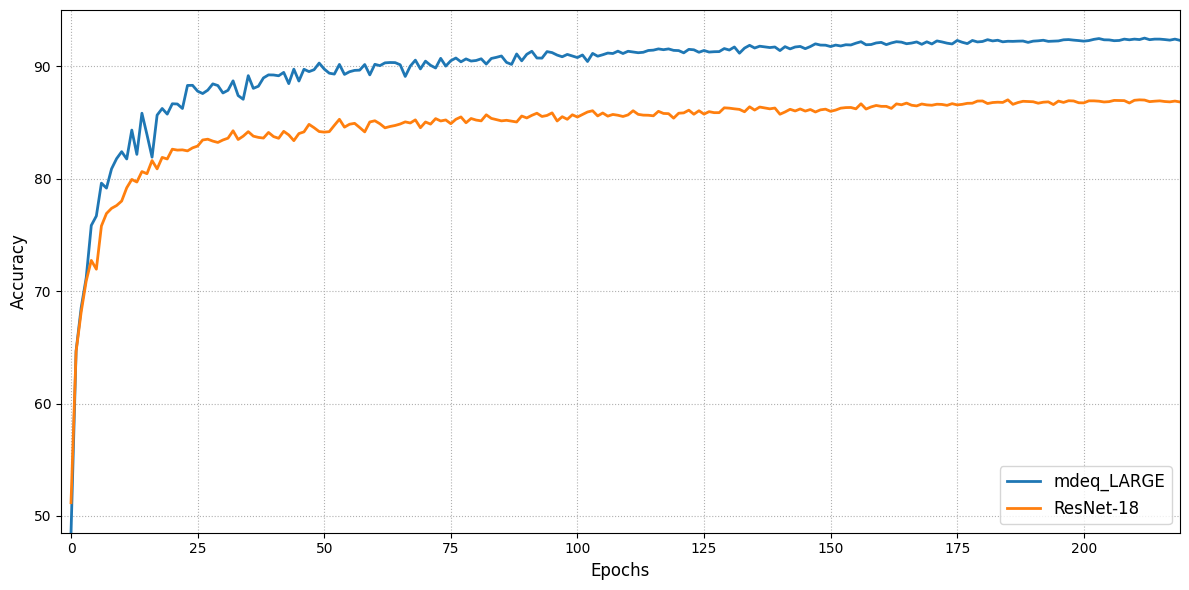

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(epochs1_test, accuracies1_test, label='mdeq_LARGE', linewidth=2, color='tab:blue')
plt.plot(epochs2_test, accuracies2_test, label='ResNet-18', linewidth=2, color='tab:orange')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
#plt.title('Evolución de la precisión en test', fontsize=16)
plt.xlim(-2, max(max(epochs1_test), max(epochs2_test)))
plt.ylim(min(min(accuracies1_test), min(accuracies2_test)), 95)
plt.legend(loc='lower right', fontsize=12)
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('figuras/primero-precision-en-test.png')
plt.show()

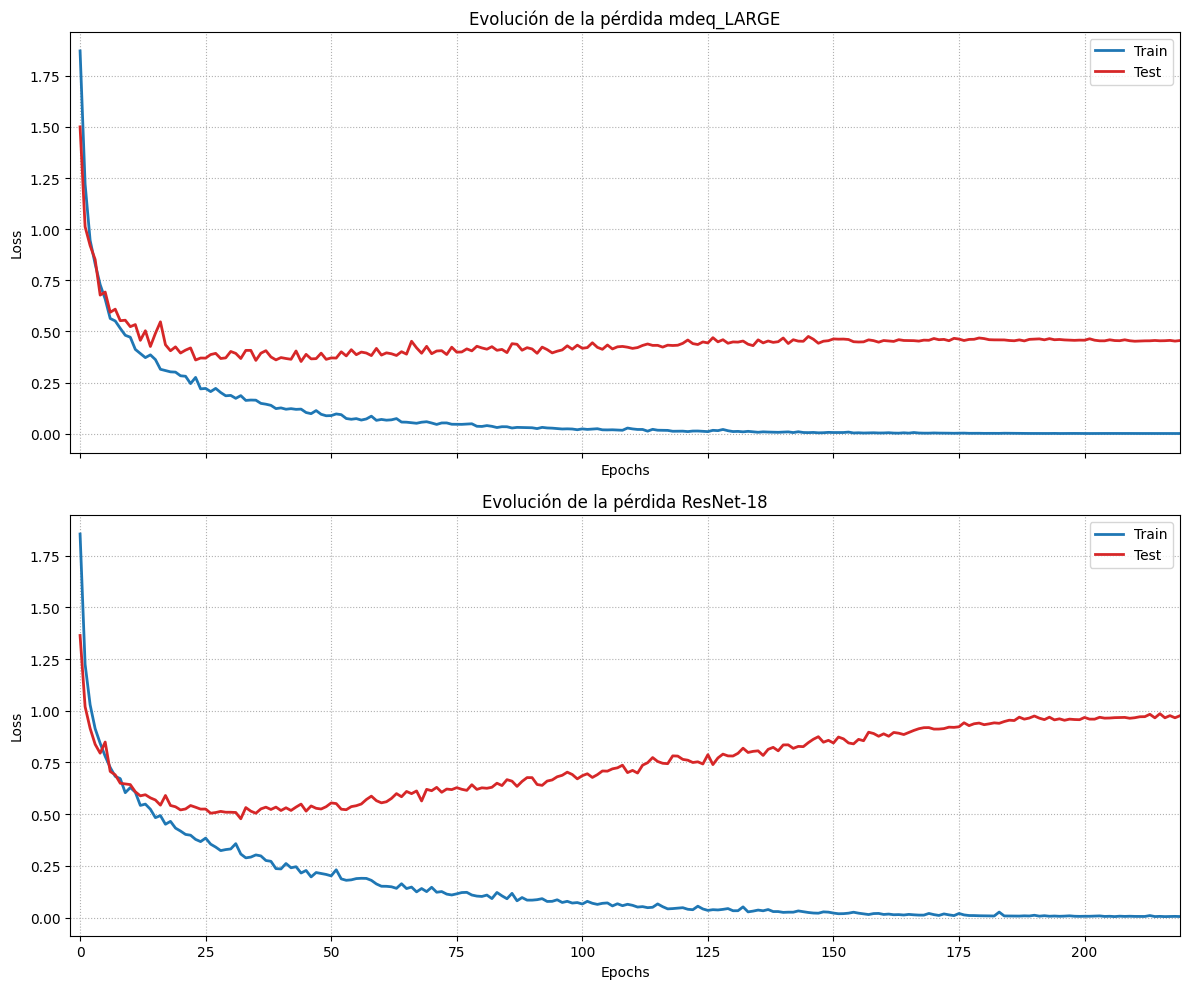

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ax1.plot(epochs1_train, losses1_train, label='Train', linewidth=2, color='tab:blue')
ax1.plot(epochs1_test, losses1_test, label='Test', linewidth=2, color='tab:red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Evolución de la pérdida mdeq_LARGE')
ax1.grid(linestyle='dotted')
ax1.legend()

ax2.plot(epochs2_train, losses2_train, label='Train', linewidth=2, color='tab:blue')
ax2.plot(epochs2_test, losses2_test, label='Test', linewidth=2, color='tab:red')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Evolución de la pérdida ResNet-18')
ax2.grid(linestyle='dotted')
ax2.legend()

plt.xlim(-2, max(max(epochs1_train), max(epochs1_test)))
plt.tight_layout()

plt.show()

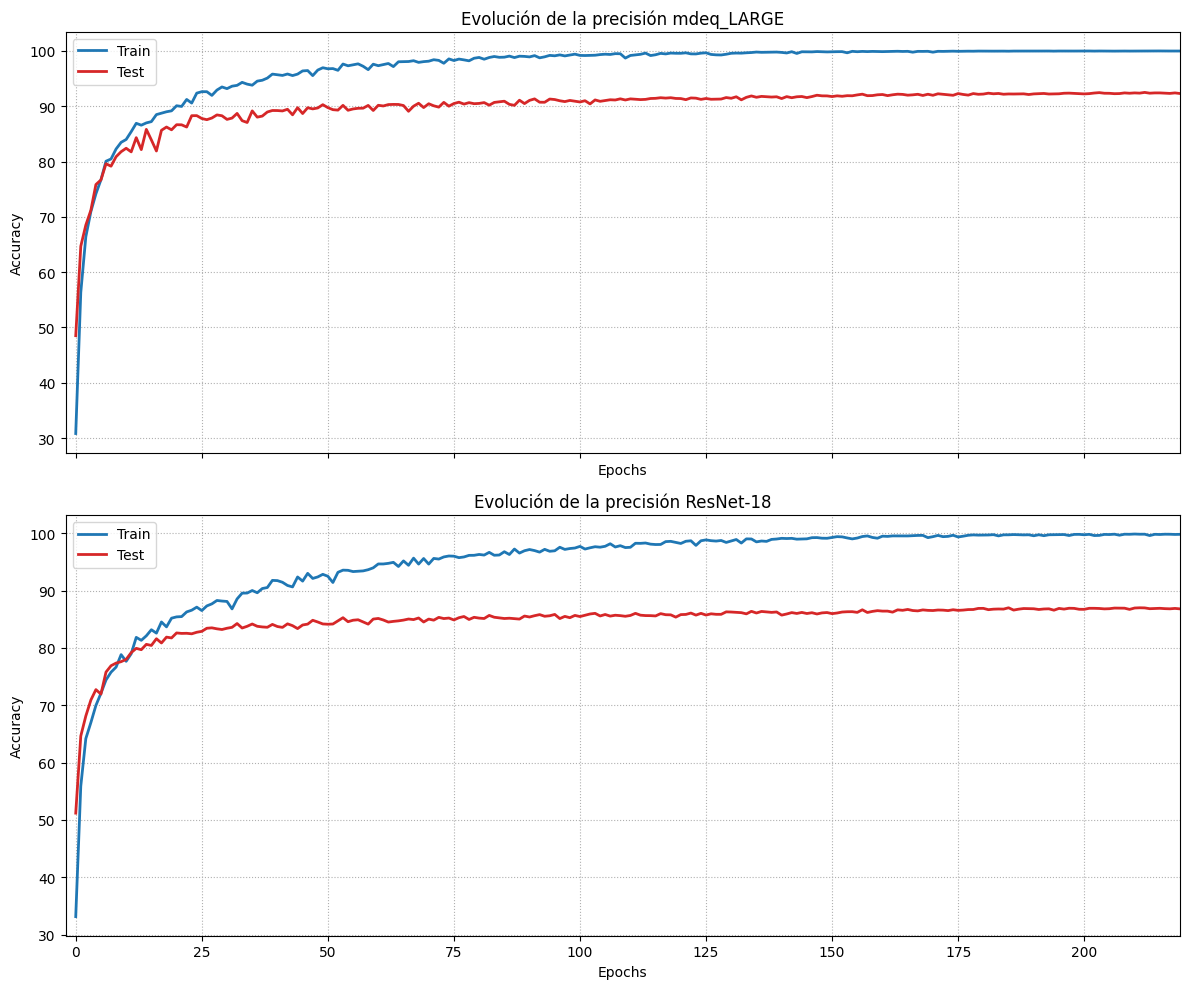

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ax1.plot(epochs1_train, accuracies1_train, label='Train', linewidth=2, color='tab:blue')
ax1.plot(epochs1_test, accuracies1_test, label='Test', linewidth=2, color='tab:red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Evolución de la precisión mdeq_LARGE')
ax1.grid(linestyle='dotted')
ax1.legend()

ax2.plot(epochs2_train, accuracies2_train, label='Train', linewidth=2, color='tab:blue')
ax2.plot(epochs2_test, accuracies2_test, label='Test', linewidth=2, color='tab:red')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Evolución de la precisión ResNet-18')
ax2.grid(linestyle='dotted')
ax2.legend()

plt.xlim(-2, max(max(epochs1_train), max(epochs1_test)))
plt.tight_layout()

plt.show()

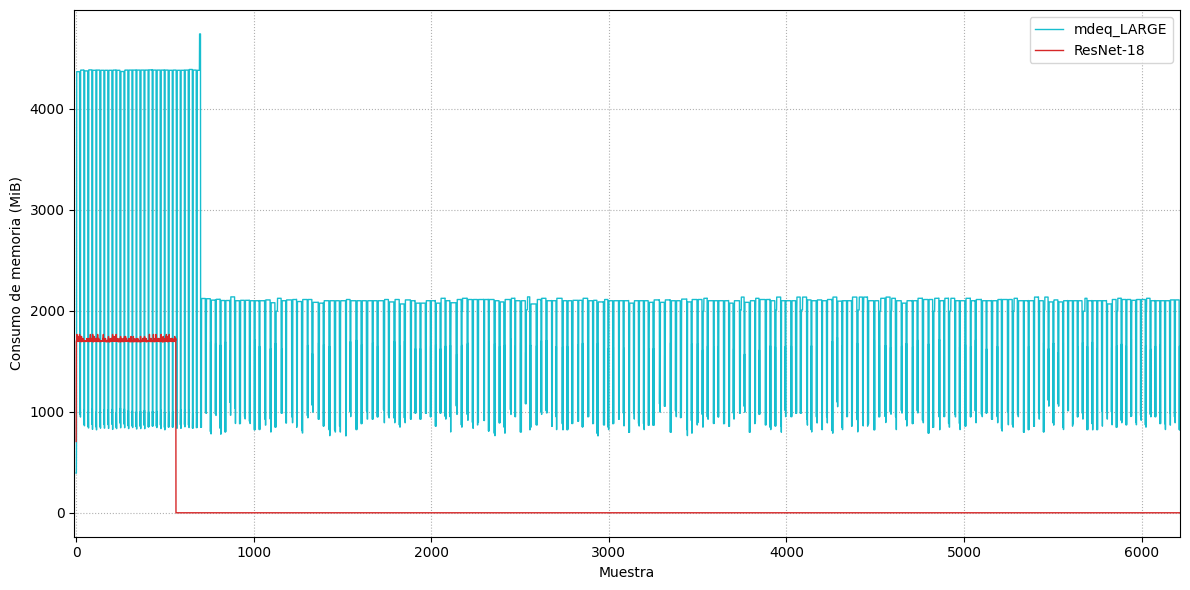

In [14]:
max_length = max(len(consumption1), len(consumption2))
# como un proceso tarda mas que el otro, relleno con 0s
consumption1 = consumption1 + [0]*(max_length - len(consumption1))
consumption2 = consumption2 + [0]*(max_length - len(consumption2))

plt.figure(figsize=(12, 6))
plt.plot(consumption1,  label='mdeq_LARGE', linewidth=1, color='tab:cyan')
plt.plot(consumption2, label='ResNet-18', linewidth=1, color='tab:red')
plt.xlabel('Muestra')
plt.ylabel('Consumo de memoria (MiB)')
plt.xlim(-10, max_length)
#plt.title('Evolución del consumo de memoria')
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.legend()
plt.savefig('figuras/primero-gpu.png')

# Mostrar el gráfico
plt.show()

### Segundo experimento: mdeq_SMALL vs ResNet-34 vs ResNet-50 en BIRDS

In [38]:
current_dir = os.getcwd()
file_path1 = os.path.join(current_dir, 'deq', 'output', 'mdeq_SMALL-birds_train.log')
epochs1_train, losses1_train, accuracies1_train = extract_train_data(file_path1)
# como hay varias tomas dentro de una misma época, hacemos la media
indexes = [i for i,x in enumerate(epochs1_train) if i == 0 or x != epochs1_train[i-1]] + [len(epochs1_train)-1]
epochs1_train = list(set(epochs1_train))
losses1_train = [sum(losses1_train[indexes[i]:indexes[i+1]]) / len(losses1_train[indexes[i]:indexes[i+1]]) for i in range(len(indexes)-1)]
accuracies1_train = [sum(accuracies1_train[indexes[i]:indexes[i+1]]) / len(accuracies1_train[indexes[i]:indexes[i+1]]) for i in range(len(indexes)-1)]
epochs1_test, losses1_test, accuracies1_test = extract_test_data(file_path1)
runtime1 = extract_runtime(file_path1)
file_path1 = os.path.join(current_dir, 'deq', 'memory_usage', 'mdeq_SMALL-birds_memory.txt')
_, gpu_uuid1, consumption1 = extract_memory_data(file_path1)
print('-- mdeq_SMALL-birds --')
print(' Precisión en test:', accuracies1_test[-1])
print(' Mejor precisión en test:', max(accuracies1_test), 'en época:', np.argmax(accuracies1_test))
print(' Épocas:', max(epochs1_train)+1)
print(' Tiempo de ejecución:', runtime1[0], 'horas,', runtime1[1], 'minutos,', runtime1[2], 'segundos')
print(' Consumo GPU medio (MB): {:.2f}'.format(sum(consumption1) / len(consumption1)))
print('----')

-- mdeq_SMALL-birds --
 Precisión en test: 97.027
 Mejor precisión en test: 97.066 en época: 91
 Épocas: 100
 Tiempo de ejecución: 7 horas, 7 minutos, 20 segundos
 Consumo GPU medio (MB): 3108.29
----


In [39]:
file_path2 = os.path.join(current_dir, 'explicitos', 'output', 'resnet34-birds_train.log')
epochs2_train, losses2_train, accuracies2_train = extract_train_data(file_path2)
# como hay varias tomas dentro de una misma época, hacemos la media
indexes = [i for i,x in enumerate(epochs2_train) if i == 0 or x != epochs2_train[i-1]] + [len(epochs2_train)-1]
epochs2_train = list(set(epochs2_train))
losses2_train = [sum(losses2_train[indexes[i]:indexes[i+1]]) / len(losses2_train[indexes[i]:indexes[i+1]]) for i in range(len(indexes)-1)]
accuracies2_train = [sum(accuracies2_train[indexes[i]:indexes[i+1]]) / len(accuracies2_train[indexes[i]:indexes[i+1]]) for i in range(len(indexes)-1)]
epochs2_test, losses2_test, accuracies2_test = extract_test_data(file_path2)
runtime2 = extract_runtime(file_path2)
file_path2 = os.path.join(current_dir, 'explicitos', 'memory_usage', 'resnet34-birds_memory.txt')
_, gpu_uuid2, consumption2 = extract_memory_data(file_path2)
print('-- resnet34-birds --')
print(' Precisión en test:', accuracies2_test[-1])
print(' Mejor precisión en test:', max(accuracies2_test), 'en época:', np.argmax(accuracies2_test))
print(' Épocas:', max(epochs2_train)+1)
print(' Tiempo de ejecución:', runtime2[0], 'horas,', runtime2[1], 'minutos,', runtime2[2], 'segundos')
print(' Consumo GPU medio (MB): {:.2f}'.format(sum(consumption2) / len(consumption2)))
print('----')

-- resnet34-birds --
 Precisión en test: 97.07
 Mejor precisión en test: 97.18 en época: 82
 Épocas: 100
 Tiempo de ejecución: 6 horas, 1 minutos, 52 segundos
 Consumo GPU medio (MB): 2497.10
----


In [40]:
file_path3 = os.path.join(current_dir, 'explicitos', 'output', 'resnet50-birds_train.log')
epochs3_train, losses3_train, accuracies3_train = extract_train_data(file_path3)
# como hay varias tomas dentro de una misma época, hacemos la media
indexes = [i for i,x in enumerate(epochs3_train) if i == 0 or x != epochs3_train[i-1]] + [len(epochs3_train)-1]
epochs3_train = list(set(epochs3_train))
losses3_train = [sum(losses3_train[indexes[i]:indexes[i+1]]) / len(losses3_train[indexes[i]:indexes[i+1]]) for i in range(len(indexes)-1)]
accuracies3_train = [sum(accuracies3_train[indexes[i]:indexes[i+1]]) / len(accuracies3_train[indexes[i]:indexes[i+1]]) for i in range(len(indexes)-1)]
epochs3_test, losses3_test, accuracies3_test = extract_test_data(file_path3)
runtime3 = extract_runtime(file_path3)
file_path3 = os.path.join(current_dir, 'explicitos', 'memory_usage', 'resnet50-birds_memory.txt')
_, gpu_uuid3, consumption3 = extract_memory_data(file_path3)
print('-- resnet50-birds --')
print(' Precisión en test:', accuracies3_test[-1])
print(' Mejor precisión en test:', max(accuracies3_test), 'en época:', np.argmax(accuracies3_test))
print(' Épocas:', max(epochs3_train)+1)
print(' Tiempo de ejecución:', runtime3[0], 'horas,', runtime3[1], 'minutos,', runtime3[2], 'segundos')
print(' Consumo GPU medio (MB): {:.2f}'.format(sum(consumption3) / len(consumption3)))
print('----')

-- resnet50-birds --
 Precisión en test: 97.14
 Mejor precisión en test: 97.29 en época: 92
 Épocas: 100
 Tiempo de ejecución: 7 horas, 56 minutos, 52 segundos
 Consumo GPU medio (MB): 3467.07
----


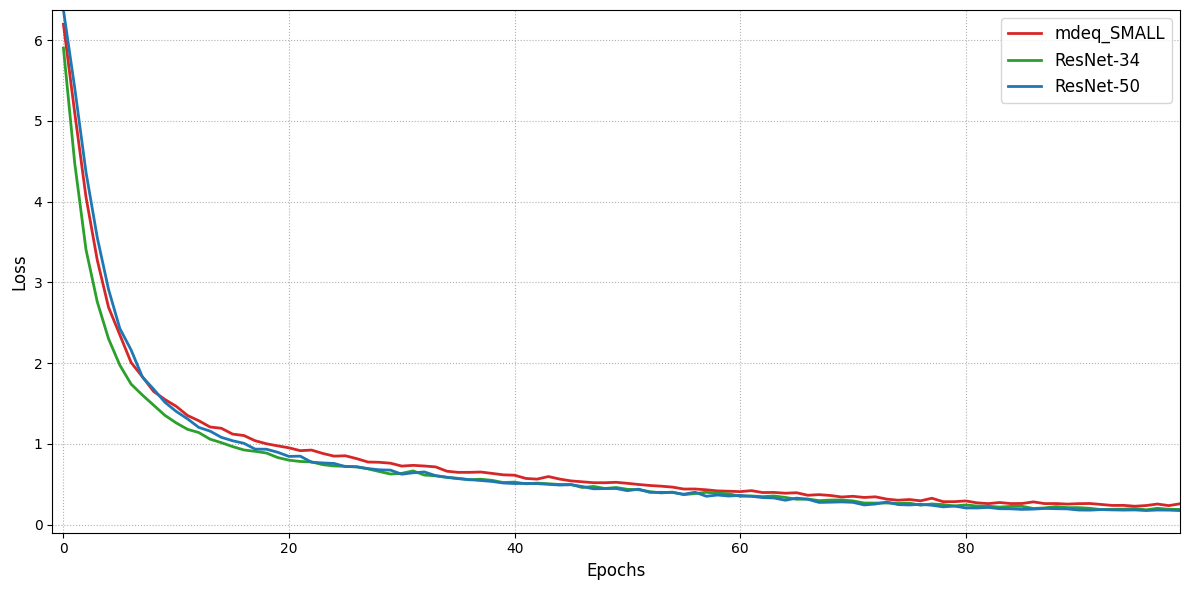

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(epochs1_train, losses1_train, label='mdeq_SMALL', linewidth=2, color='tab:red')
plt.plot(epochs2_train, losses2_train, label='ResNet-34', linewidth=2, color='tab:green')
plt.plot(epochs3_train, losses3_train, label='ResNet-50', linewidth=2, color='tab:blue')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
#plt.title('Evolución de la pérdida en train', fontsize=16)
plt.xlim(-1, max(max(epochs1_train), max(epochs2_train), max(epochs3_train)))
plt.ylim(-0.1, max(max(losses1_train), max(losses2_train), max(losses3_train)))
plt.legend(loc='upper right', fontsize=12)
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('figuras/tercero-perdida-en-train.png')
plt.show()

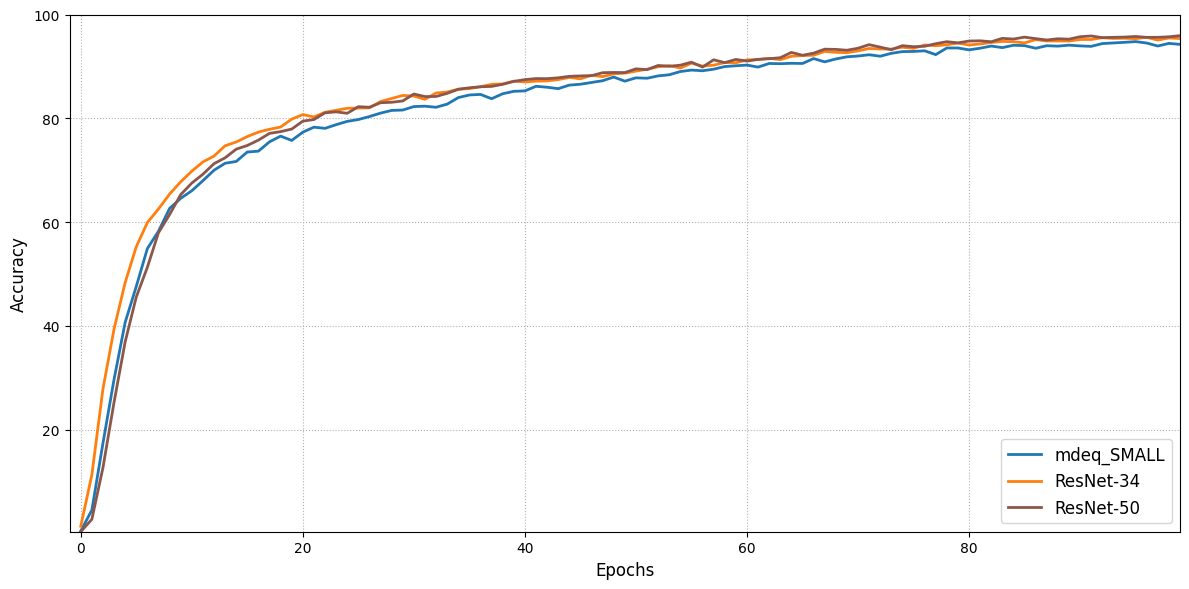

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(epochs1_train, accuracies1_train, label='mdeq_SMALL', linewidth=2, color='tab:blue')
plt.plot(epochs2_train, accuracies2_train, label='ResNet-34', linewidth=2, color='tab:orange')
plt.plot(epochs3_train, accuracies3_train, label='ResNet-50', linewidth=2, color='tab:brown')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
#plt.title('Evolución de la precisión en train', fontsize=16)
plt.xlim(-1, max(max(epochs1_train), max(epochs2_train), max(epochs3_train)))
plt.ylim(min(min(accuracies1_train), min(accuracies2_train), min(accuracies3_train)), 100)
plt.legend(loc='lower right', fontsize=12)
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('figuras/tercero-precision-en-train.png')
plt.show()

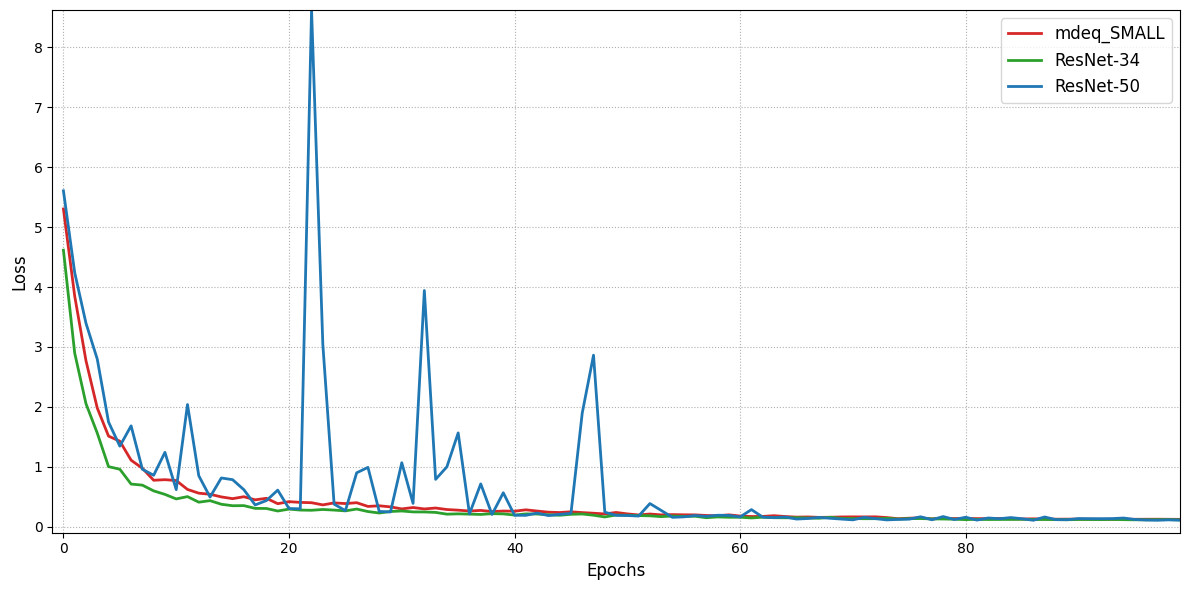

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(epochs1_test, losses1_test, label='mdeq_SMALL', linewidth=2, color='tab:red')
plt.plot(epochs2_test, losses2_test, label='ResNet-34', linewidth=2, color='tab:green')
plt.plot(epochs3_test, losses3_test, label='ResNet-50', linewidth=2, color='tab:blue')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
#plt.title('Evolución de la pérdida en test', fontsize=16)
plt.xlim(-1, max(max(epochs1_test), max(epochs2_test), max(epochs3_test)))
plt.ylim(-0.1, max(max(losses1_test), max(losses2_test), max(losses3_test)))
plt.legend(loc='upper right', fontsize=12)
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('figuras/tercero-perdida-en-test.png')
plt.show()

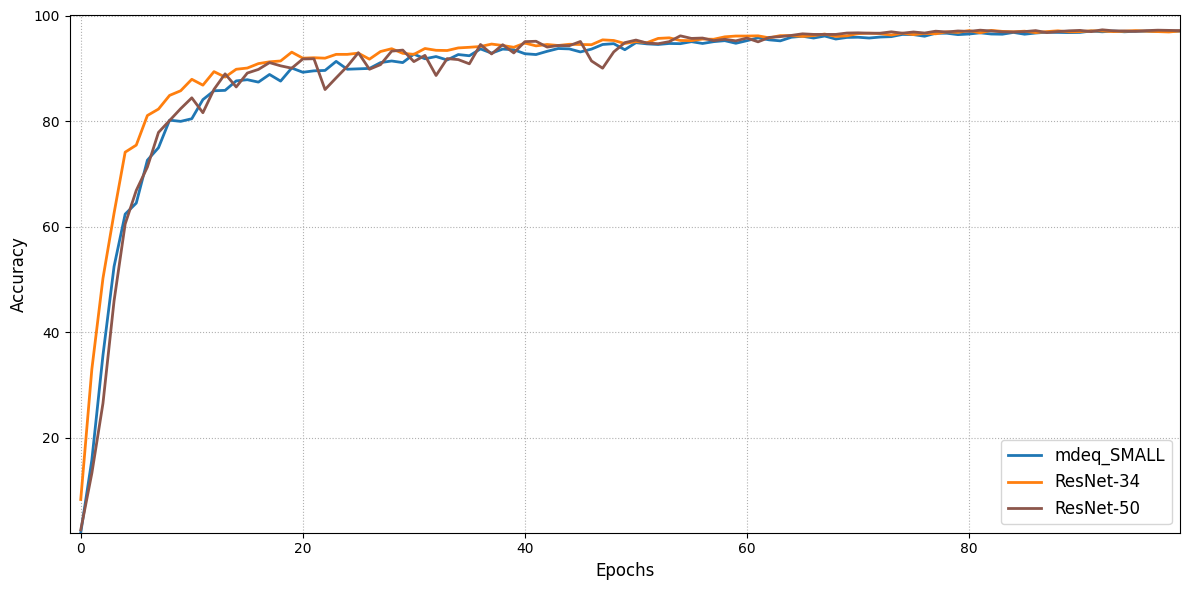

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(epochs1_test, accuracies1_test, label='mdeq_SMALL', linewidth=2, color='tab:blue')
plt.plot(epochs2_test, accuracies2_test, label='ResNet-34', linewidth=2, color='tab:orange')
plt.plot(epochs3_test, accuracies3_test, label='ResNet-50', linewidth=2, color='tab:brown')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
#plt.title('Evolución de la precisión en test', fontsize=16)
plt.xlim(-1, max(max(epochs1_test), max(epochs2_test), max(epochs3_test)))
plt.ylim(min(min(accuracies1_test), min(accuracies2_test), min(accuracies3_test)), 100)
plt.legend(loc='lower right', fontsize=12)
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('figuras/tercero-precision-en-test.png')
plt.show()

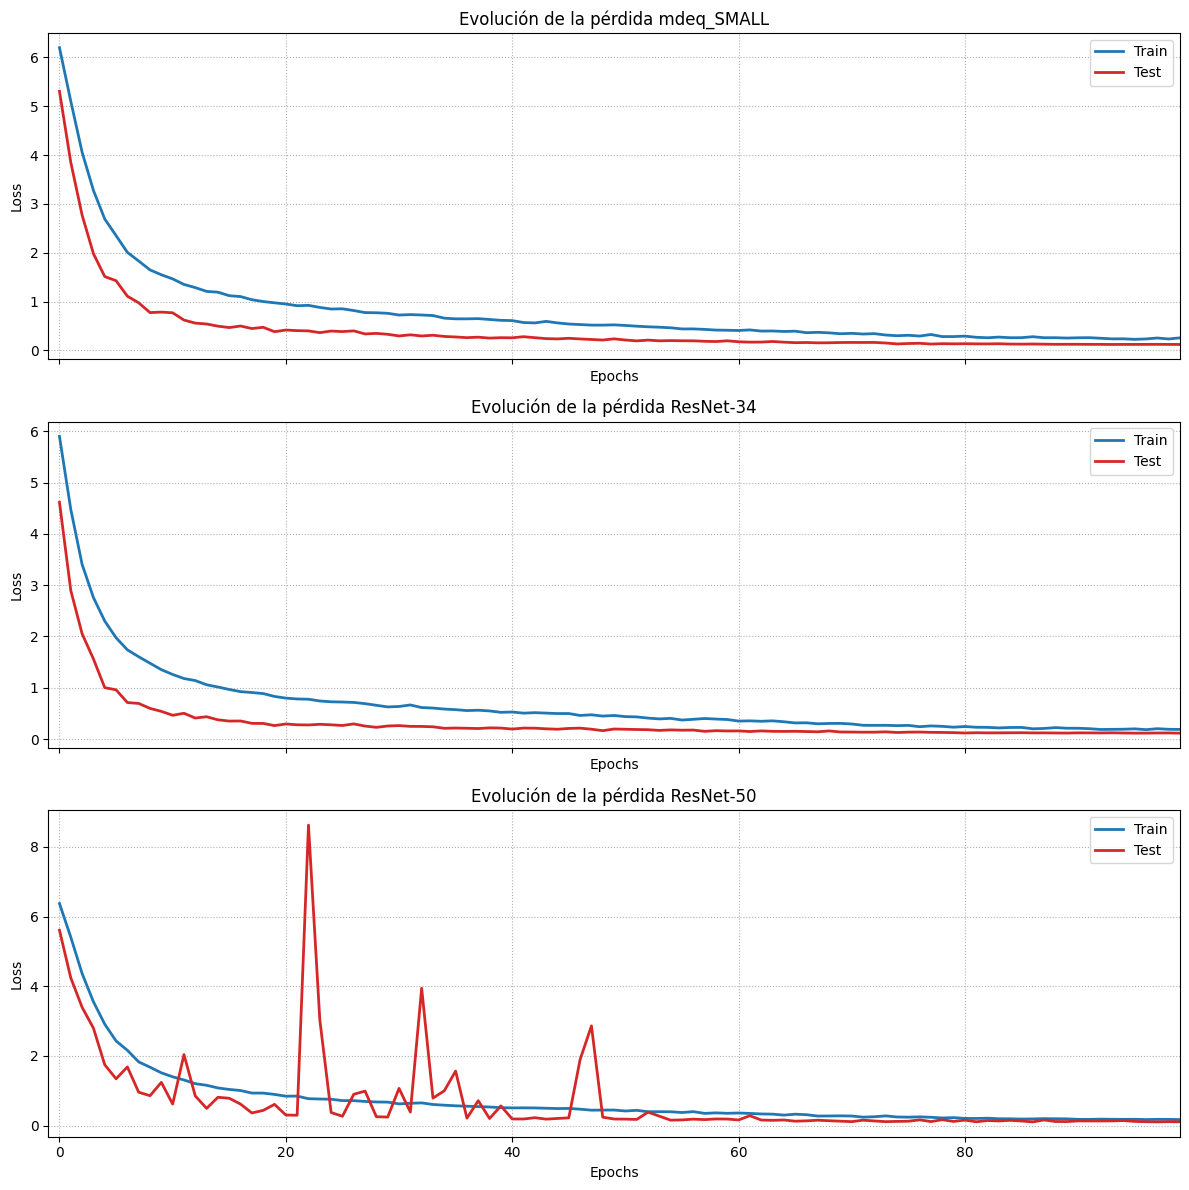

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

ax1.plot(epochs1_train, losses1_train, label='Train', linewidth=2, color='tab:blue')
ax1.plot(epochs1_test, losses1_test, label='Test', linewidth=2, color='tab:red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Evolución de la pérdida mdeq_SMALL')
ax1.grid(linestyle='dotted')
ax1.legend()

ax2.plot(epochs2_train, losses2_train, label='Train', linewidth=2, color='tab:blue')
ax2.plot(epochs2_test, losses2_test, label='Test', linewidth=2, color='tab:red')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Evolución de la pérdida ResNet-34')
ax2.grid(linestyle='dotted')
ax2.legend()

ax3.plot(epochs3_train, losses3_train, label='Train', linewidth=2, color='tab:blue')
ax3.plot(epochs3_test, losses3_test, label='Test', linewidth=2, color='tab:red')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.set_title('Evolución de la pérdida ResNet-50')
ax3.grid(linestyle='dotted')
ax3.legend()

plt.xlim(-1, max(max(epochs1_train), max(epochs1_test)))
plt.tight_layout()

plt.show()

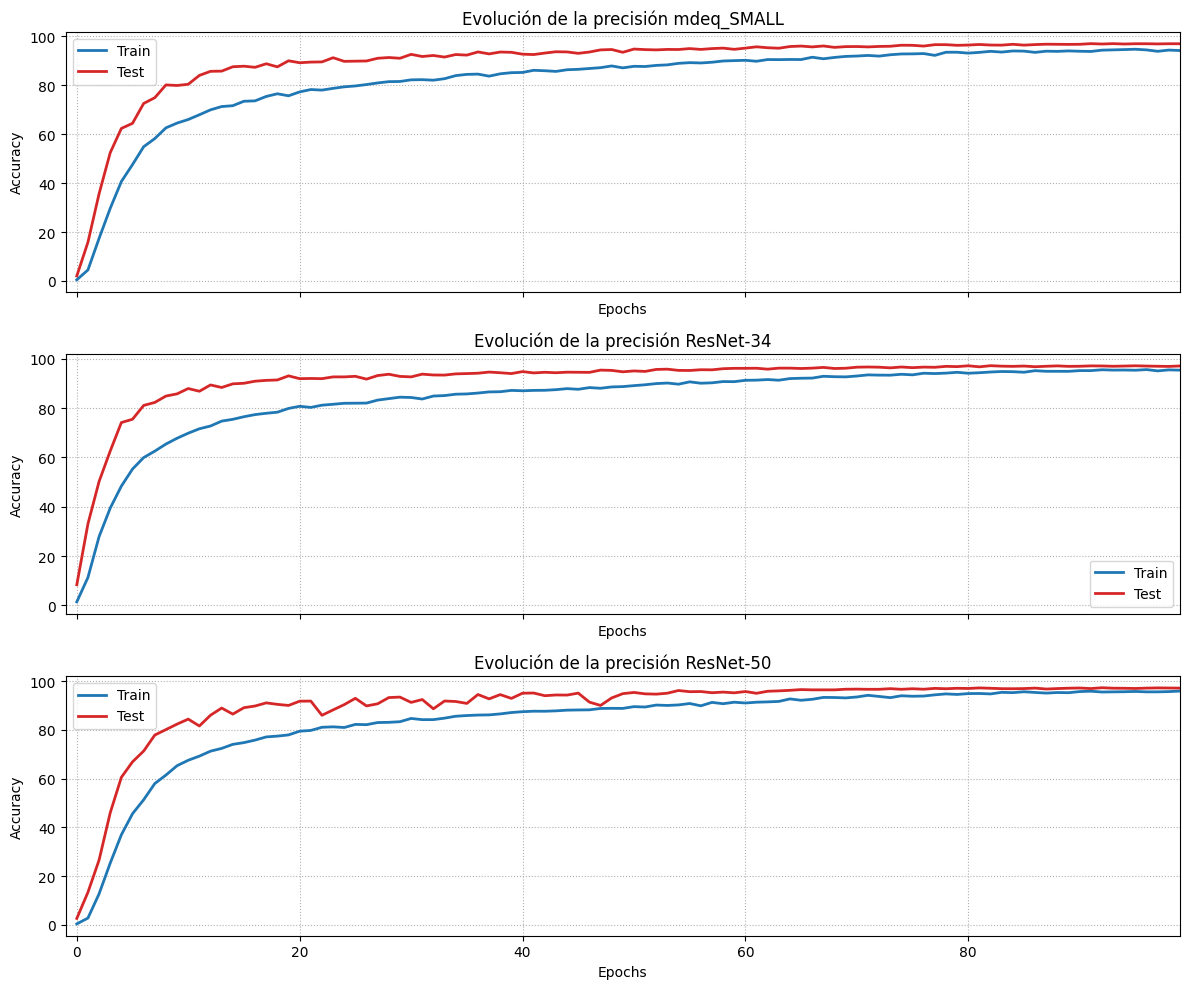

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

ax1.plot(epochs1_train, accuracies1_train, label='Train', linewidth=2, color='tab:blue')
ax1.plot(epochs1_test, accuracies1_test, label='Test', linewidth=2, color='tab:red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Evolución de la precisión mdeq_SMALL')
ax1.grid(linestyle='dotted')
ax1.legend()

ax2.plot(epochs2_train, accuracies2_train, label='Train', linewidth=2, color='tab:blue')
ax2.plot(epochs2_test, accuracies2_test, label='Test', linewidth=2, color='tab:red')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Evolución de la precisión ResNet-34')
ax2.grid(linestyle='dotted')
ax2.legend()

ax3.plot(epochs3_train, accuracies3_train, label='Train', linewidth=2, color='tab:blue')
ax3.plot(epochs3_test, accuracies3_test, label='Test', linewidth=2, color='tab:red')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Accuracy')
ax3.set_title('Evolución de la precisión ResNet-50')
ax3.grid(linestyle='dotted')
ax3.legend()

plt.xlim(-1, max(max(epochs1_train), max(epochs1_test)))
plt.tight_layout()

plt.show()

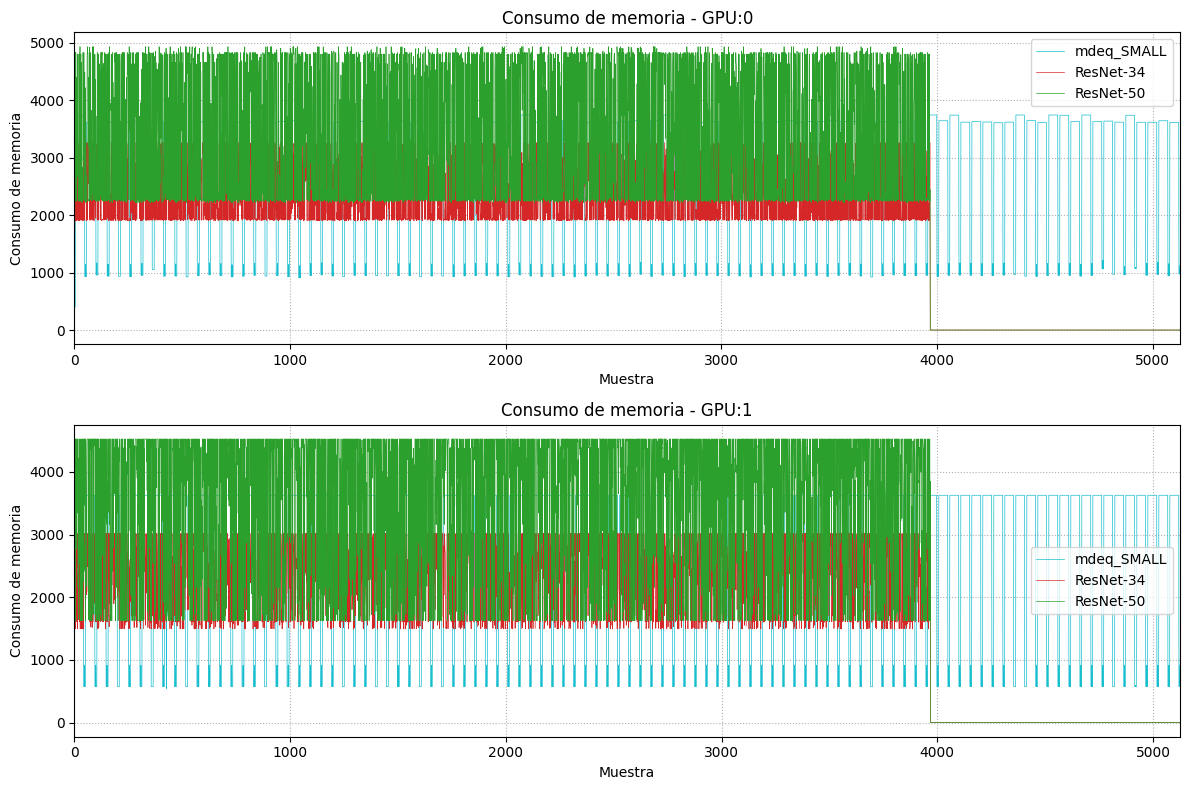

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# filtramos los datos por GPU
consumption1_uuid1 = [c for uuid, c in zip(gpu_uuid1, consumption1) if uuid == 'GPU-47539ef2-464f-67e9-5fac-2bf734641438']
consumption1_uuid2 = [c for uuid, c in zip(gpu_uuid1, consumption1) if uuid == 'GPU-3a5082a1-1b81-8b61-005c-ce2e010bdc81']
consumption2_uuid1 = [c for uuid, c in zip(gpu_uuid2, consumption2) if uuid == 'GPU-80cc54f6-7913-1b9e-7d7a-a0701a94b8b6']
consumption2_uuid2 = [c for uuid, c in zip(gpu_uuid2, consumption2) if uuid == 'GPU-248f46ce-a0c4-c614-2d6d-bff3f905e508']
consumption3_uuid1 = [c for uuid, c in zip(gpu_uuid2, consumption3) if uuid == 'GPU-80cc54f6-7913-1b9e-7d7a-a0701a94b8b6']
consumption3_uuid2 = [c for uuid, c in zip(gpu_uuid2, consumption3) if uuid == 'GPU-248f46ce-a0c4-c614-2d6d-bff3f905e508']

max_length1 = max(len(consumption1_uuid1), len(consumption2_uuid1), len(consumption3_uuid1))
max_length2 = max(len(consumption1_uuid2), len(consumption2_uuid2), len(consumption3_uuid2))
# como un proceso tarda mas que el otro, relleno con 0s
consumption1_uuid1 = consumption1_uuid1 + [0]*(max_length1 - len(consumption1_uuid1))
consumption2_uuid1 = consumption2_uuid1 + [0]*(max_length1 - len(consumption2_uuid1))
consumption3_uuid1 = consumption3_uuid1 + [0]*(max_length1 - len(consumption3_uuid1))
consumption1_uuid2 = consumption1_uuid2 + [0]*(max_length2 - len(consumption1_uuid2))
consumption2_uuid2 = consumption2_uuid2 + [0]*(max_length2 - len(consumption2_uuid2))
consumption3_uuid2 = consumption3_uuid2 + [0]*(max_length2 - len(consumption3_uuid2))

ax1.plot(consumption1_uuid1, label='mdeq_SMALL', linewidth=0.5, color='tab:cyan')
ax2.plot(consumption1_uuid2, label='mdeq_SMALL', linewidth=0.5, color='tab:cyan')
ax1.plot(consumption2_uuid1, label='ResNet-34', linewidth=0.5, color='tab:red')
ax2.plot(consumption2_uuid2, label='ResNet-34', linewidth=0.5, color='tab:red')
ax1.plot(consumption3_uuid1, label='ResNet-50', linewidth=0.5, color='tab:green')
ax2.plot(consumption3_uuid2, label='ResNet-50', linewidth=0.5, color='tab:green')

ax1.set_xlabel('Muestra')
ax1.set_ylabel('Consumo de memoria')
ax1.set_title('Consumo de memoria - GPU:0')
ax1.set_xlim(0, max_length1)
ax1.grid(linestyle='dotted')
ax1.legend()

ax2.set_xlabel('Muestra')
ax2.set_ylabel('Consumo de memoria')
ax2.set_title('Consumo de memoria - GPU:1')
ax2.set_xlim(0, max_length2)
ax2.grid(linestyle='dotted')
ax2.legend()

plt.tight_layout()

plt.savefig('figuras/tercero-gpu0.png')

plt.show()

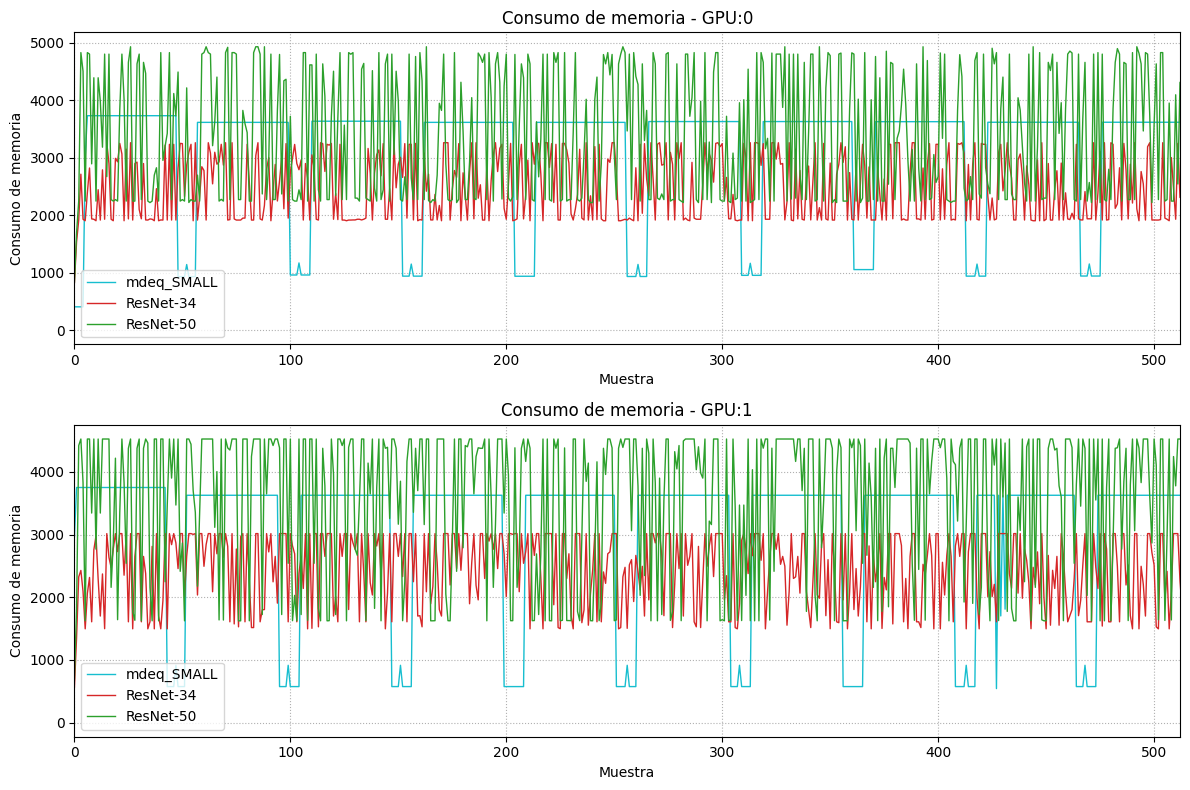

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# filtramos los datos por GPU
consumption1_uuid1 = [c for uuid, c in zip(gpu_uuid1, consumption1) if uuid == 'GPU-47539ef2-464f-67e9-5fac-2bf734641438']
consumption1_uuid2 = [c for uuid, c in zip(gpu_uuid1, consumption1) if uuid == 'GPU-3a5082a1-1b81-8b61-005c-ce2e010bdc81']
consumption2_uuid1 = [c for uuid, c in zip(gpu_uuid2, consumption2) if uuid == 'GPU-80cc54f6-7913-1b9e-7d7a-a0701a94b8b6']
consumption2_uuid2 = [c for uuid, c in zip(gpu_uuid2, consumption2) if uuid == 'GPU-248f46ce-a0c4-c614-2d6d-bff3f905e508']
consumption3_uuid1 = [c for uuid, c in zip(gpu_uuid2, consumption3) if uuid == 'GPU-80cc54f6-7913-1b9e-7d7a-a0701a94b8b6']
consumption3_uuid2 = [c for uuid, c in zip(gpu_uuid2, consumption3) if uuid == 'GPU-248f46ce-a0c4-c614-2d6d-bff3f905e508']

max_length1 = max(len(consumption1_uuid1), len(consumption2_uuid1), len(consumption3_uuid1))
max_length2 = max(len(consumption1_uuid2), len(consumption2_uuid2), len(consumption3_uuid2))
# como un proceso tarda mas que el otro, relleno con 0s
consumption1_uuid1 = consumption1_uuid1 + [0]*(max_length1 - len(consumption1_uuid1))
consumption2_uuid1 = consumption2_uuid1 + [0]*(max_length1 - len(consumption2_uuid1))
consumption3_uuid1 = consumption3_uuid1 + [0]*(max_length1 - len(consumption3_uuid1))
consumption1_uuid2 = consumption1_uuid2 + [0]*(max_length2 - len(consumption1_uuid2))
consumption2_uuid2 = consumption2_uuid2 + [0]*(max_length2 - len(consumption2_uuid2))
consumption3_uuid2 = consumption3_uuid2 + [0]*(max_length2 - len(consumption3_uuid2))

ax1.plot(consumption1_uuid1, label='mdeq_SMALL', linewidth=1, color='tab:cyan')
ax2.plot(consumption1_uuid2, label='mdeq_SMALL', linewidth=1, color='tab:cyan')
ax1.plot(consumption2_uuid1, label='ResNet-34', linewidth=1, color='tab:red')
ax2.plot(consumption2_uuid2, label='ResNet-34', linewidth=1, color='tab:red')
ax1.plot(consumption3_uuid1, label='ResNet-50', linewidth=1, color='tab:green')
ax2.plot(consumption3_uuid2, label='ResNet-50', linewidth=1, color='tab:green')

ax1.set_xlabel('Muestra')
ax1.set_ylabel('Consumo de memoria')
ax1.set_title('Consumo de memoria - GPU:0')
ax1.set_xlim(0, max_length1//10)
ax1.grid(linestyle='dotted')
ax1.legend()

ax2.set_xlabel('Muestra')
ax2.set_ylabel('Consumo de memoria')
ax2.set_title('Consumo de memoria - GPU:1')
ax2.set_xlim(0, max_length2//10)
ax2.grid(linestyle='dotted')
ax2.legend()

plt.tight_layout()

plt.savefig('figuras/tercero-gpu1.png')

plt.show()

### Tercer experimento: mdeq_LARGE vs ResNet-101 vs DenseNet-121

In [26]:
current_dir = os.getcwd()
file_path1 = os.path.join(current_dir, 'deq', 'output', 'mdeq_LARGE-memory_train.log')
epochs1_train, losses1_train, accuracies1_train = extract_train_data(file_path1)
# como hay varias tomas dentro de una misma época, hacemos la media
indexes = [i for i,x in enumerate(epochs1_train) if i == 0 or x != epochs1_train[i-1]] + [len(epochs1_train)-1]
epochs1_train = list(set(epochs1_train))
losses1_train = [sum(losses1_train[indexes[i]:indexes[i+1]]) / len(losses1_train[indexes[i]:indexes[i+1]]) for i in range(len(indexes)-1)]
accuracies1_train = [sum(accuracies1_train[indexes[i]:indexes[i+1]]) / len(accuracies1_train[indexes[i]:indexes[i+1]]) for i in range(len(indexes)-1)]
epochs1_test, losses1_test, accuracies1_test = extract_test_data(file_path1)
runtime1 = extract_runtime(file_path1)
file_path1 = os.path.join(current_dir, 'deq', 'memory_usage', 'mdeq_LARGE-memory_memory.txt')
_, gpu_uuid1, consumption1 = extract_memory_data(file_path1)
print('-- mdeq_LARGE-memory --')
print(' Precisión en test:', accuracies1_test[-1])
print(' Mejor precisión en test:', max(accuracies1_test), 'en época:', np.argmax(accuracies1_test))
print(' Épocas:', max(epochs1_train)+1)
print(' Tiempo de ejecución:', runtime1[0], 'horas,', runtime1[1], 'minutos,', runtime1[2], 'segundos')
print(' Consumo GPU medio (MB): {:.2f}'.format(sum(consumption1) / len(consumption1)))
print('----')

-- mdeq_LARGE-memory --
 Precisión en test: 91.396
 Mejor precisión en test: 91.416 en época: 42
 Épocas: 50
 Tiempo de ejecución: 3 horas, 4 minutos, 49 segundos
 Consumo GPU medio (MB): 1364.57
----


In [27]:
file_path2 = os.path.join(current_dir, 'explicitos', 'output', 'resnet101-memory_train.log')
epochs2_train, losses2_train, accuracies2_train = extract_train_data(file_path2)
epochs2_test, losses2_test, accuracies2_test = extract_test_data(file_path2)
# como hay varias tomas dentro de una misma época, hacemos la media
indexes = [i for i,x in enumerate(epochs2_train) if i == 0 or x != epochs2_train[i-1]] + [len(epochs2_train)-1]
epochs2_train = list(set(epochs2_train))
losses2_train = [sum(losses2_train[indexes[i]:indexes[i+1]]) / len(losses2_train[indexes[i]:indexes[i+1]]) for i in range(len(indexes)-1)]
accuracies2_train = [sum(accuracies2_train[indexes[i]:indexes[i+1]]) / len(accuracies2_train[indexes[i]:indexes[i+1]]) for i in range(len(indexes)-1)]
runtime2 = extract_runtime(file_path2)
file_path2 = os.path.join(current_dir, 'explicitos', 'memory_usage', 'resnet101-memory_memory.txt')
_, _, consumption2 = extract_memory_data(file_path2) 
print('-- resnet101-memory --')
print(' Precisión en test:', accuracies2_test[-1])
print(' Mejor precisión en test:', max(accuracies2_test), 'en época:', np.argmax(accuracies2_test))
print(' Épocas:', max(epochs2_train)+1)
print(' Tiempo de ejecución:', runtime2[0], 'horas,', runtime2[1], 'minutos,', runtime2[2], 'segundos')
print(' Consumo GPU medio (MB): {:.2f}'.format(sum(consumption2) / len(consumption2)))
print('----')

-- resnet101-memory --
 Precisión en test: 84.96
 Mejor precisión en test: 84.96 en época: 49
 Épocas: 50
 Tiempo de ejecución: 1 horas, 48 minutos, 21 segundos
 Consumo GPU medio (MB): 2381.60
----


In [28]:
file_path3 = os.path.join(current_dir, 'explicitos', 'output', 'densenet121-memory_train.log')
epochs3_train, losses3_train, accuracies3_train = extract_train_data(file_path3)
# como hay varias tomas dentro de una misma época, hacemos la media
indexes = [i for i,x in enumerate(epochs3_train) if i == 0 or x != epochs3_train[i-1]] + [len(epochs3_train)-1]
epochs3_train = list(set(epochs3_train))
losses3_train = [sum(losses3_train[indexes[i]:indexes[i+1]]) / len(losses3_train[indexes[i]:indexes[i+1]]) for i in range(len(indexes)-1)]
accuracies3_train = [sum(accuracies3_train[indexes[i]:indexes[i+1]]) / len(accuracies3_train[indexes[i]:indexes[i+1]]) for i in range(len(indexes)-1)]
epochs3_test, losses3_test, accuracies3_test = extract_test_data(file_path3)
runtime3 = extract_runtime(file_path3)
file_path3 = os.path.join(current_dir, 'explicitos', 'memory_usage', 'densenet121-memory_memory.txt')
_, _, consumption3 = extract_memory_data(file_path3)
print('-- densenet121-memory --')
print(' Precisión en test:', accuracies3_test[-1])
print(' Mejor precisión en test:', max(accuracies3_test), 'en época:', np.argmax(accuracies3_test))
print(' Épocas:', max(epochs3_train)+1)
print(' Tiempo de ejecución:', runtime3[0], 'horas,', runtime3[1], 'minutos,', runtime3[2], 'segundos')
print(' Consumo GPU medio (MB): {:.2f}'.format(sum(consumption3) / len(consumption3)))
print('----')

-- densenet121-memory --
 Precisión en test: 86.95
 Mejor precisión en test: 87.19 en época: 44
 Épocas: 50
 Tiempo de ejecución: 1 horas, 42 minutos, 43 segundos
 Consumo GPU medio (MB): 1866.40
----


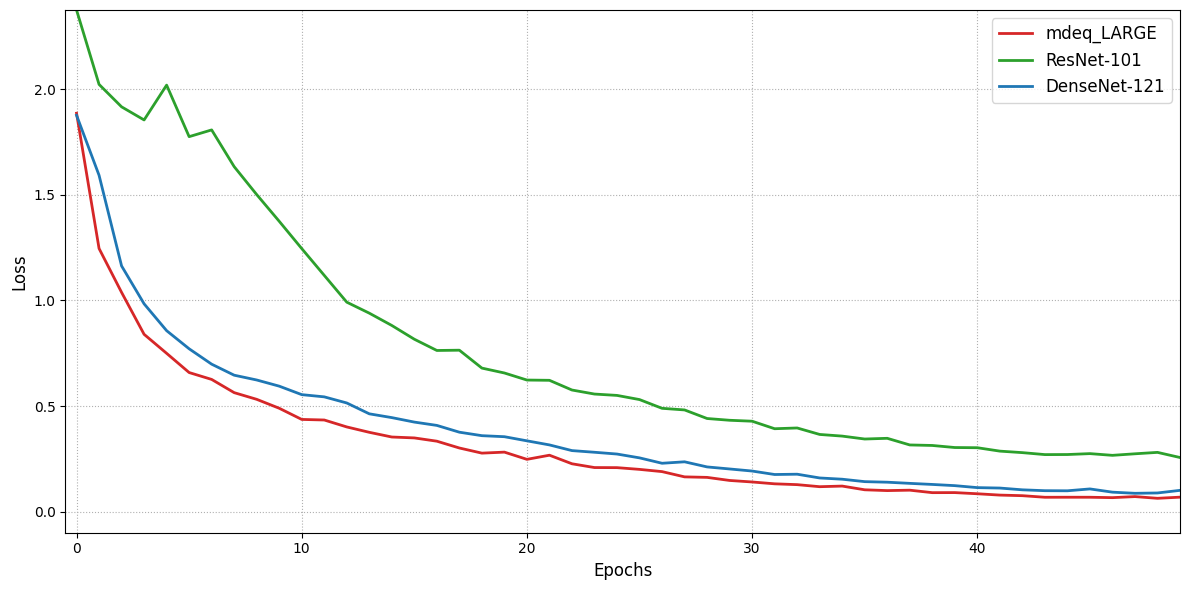

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(epochs1_train, losses1_train, label='mdeq_LARGE', linewidth=2, color='tab:red')
plt.plot(epochs2_train, losses2_train, label='ResNet-101', linewidth=2, color='tab:green')
plt.plot(epochs3_train, losses3_train, label='DenseNet-121', linewidth=2, color='tab:blue')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
#plt.title('Evolución de la pérdida en train', fontsize=16)
plt.xlim(-0.5, max(max(epochs1_train), max(epochs2_train), max(epochs3_train)))
plt.ylim(-0.1, max(max(losses1_train), max(losses2_train), max(losses3_train)))
plt.legend(loc='upper right', fontsize=12)
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('figuras/segundo-perdida-en-train.png')
plt.show()

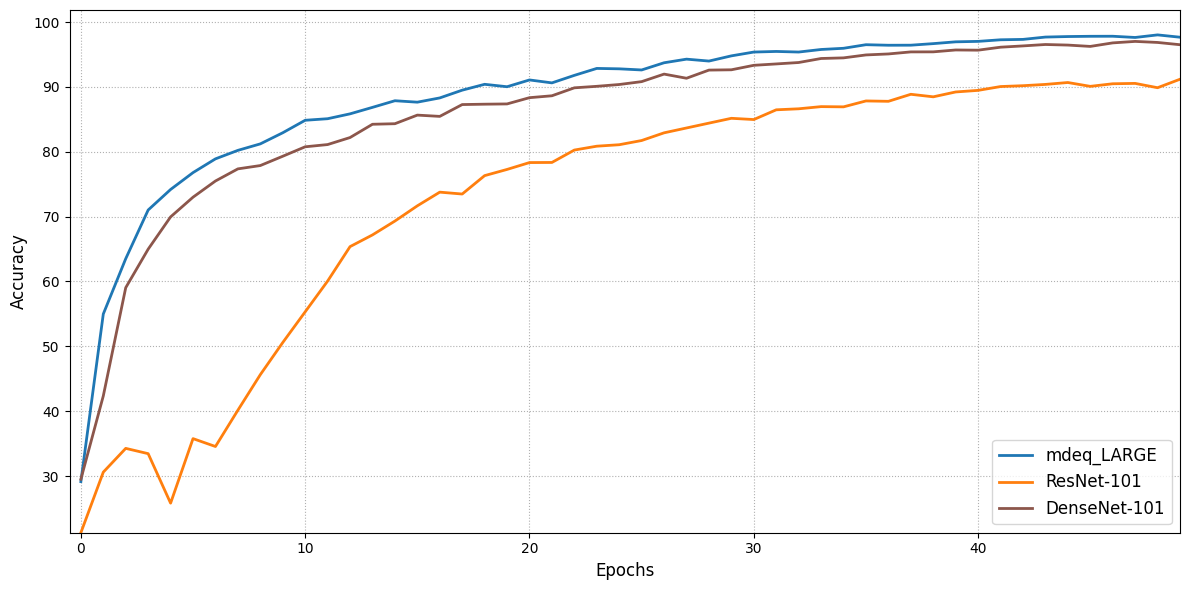

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(epochs1_train, accuracies1_train, label='mdeq_LARGE', linewidth=2, color='tab:blue')
plt.plot(epochs2_train, accuracies2_train, label='ResNet-101', linewidth=2, color='tab:orange')
plt.plot(epochs3_train, accuracies3_train, label='DenseNet-101', linewidth=2, color='tab:brown')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
#plt.title('Evolución de la precisión en train', fontsize=16)
plt.xlim(-0.5, max(max(epochs1_train), max(epochs2_train), max(epochs3_train)))
plt.ylim(min(min(accuracies1_train), min(accuracies2_train), min(accuracies3_train), 100))
plt.legend(loc='lower right', fontsize=12)
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('figuras/segundo-precision-en-train.png')
plt.show()

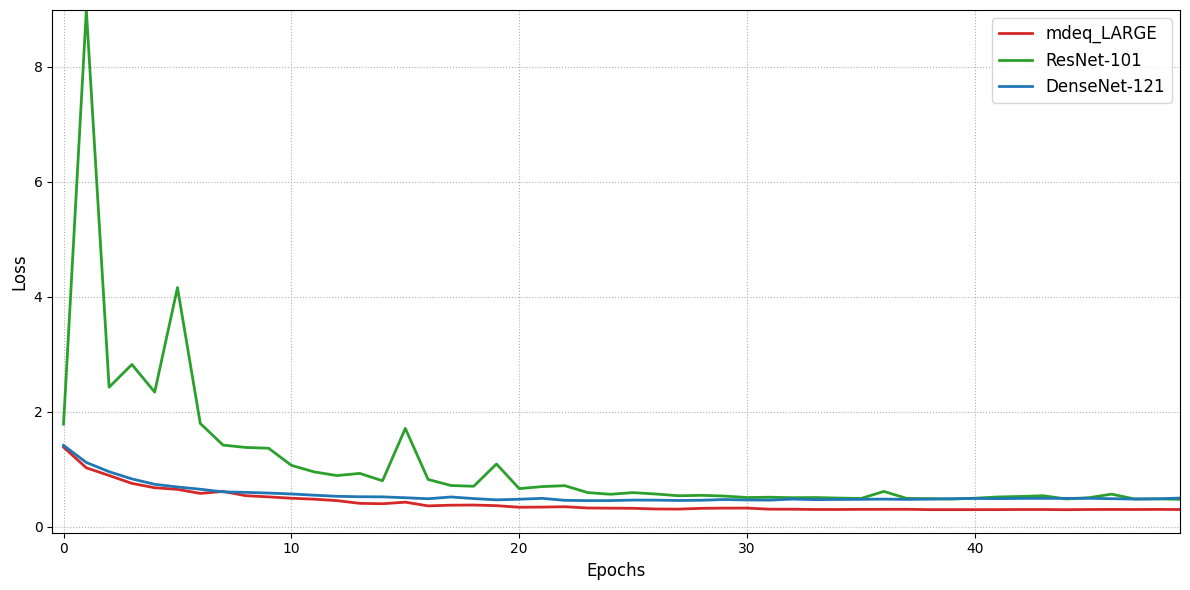

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(epochs1_test, losses1_test, label='mdeq_LARGE', linewidth=2, color='tab:red')
plt.plot(epochs2_test, losses2_test, label='ResNet-101', linewidth=2, color='tab:green')
plt.plot(epochs3_test, losses3_test, label='DenseNet-121', linewidth=2, color='tab:blue')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
#plt.title('Evolución de la pérdida en test', fontsize=16)
plt.xlim(-0.5, max(max(epochs1_test), max(epochs2_test), max(epochs3_test)))
plt.ylim(-0.1, max(max(losses1_test), max(losses2_test), max(losses3_test)))
plt.legend(loc='upper right', fontsize=12)
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('figuras/segundo-perdida-en-test.png')
plt.show()

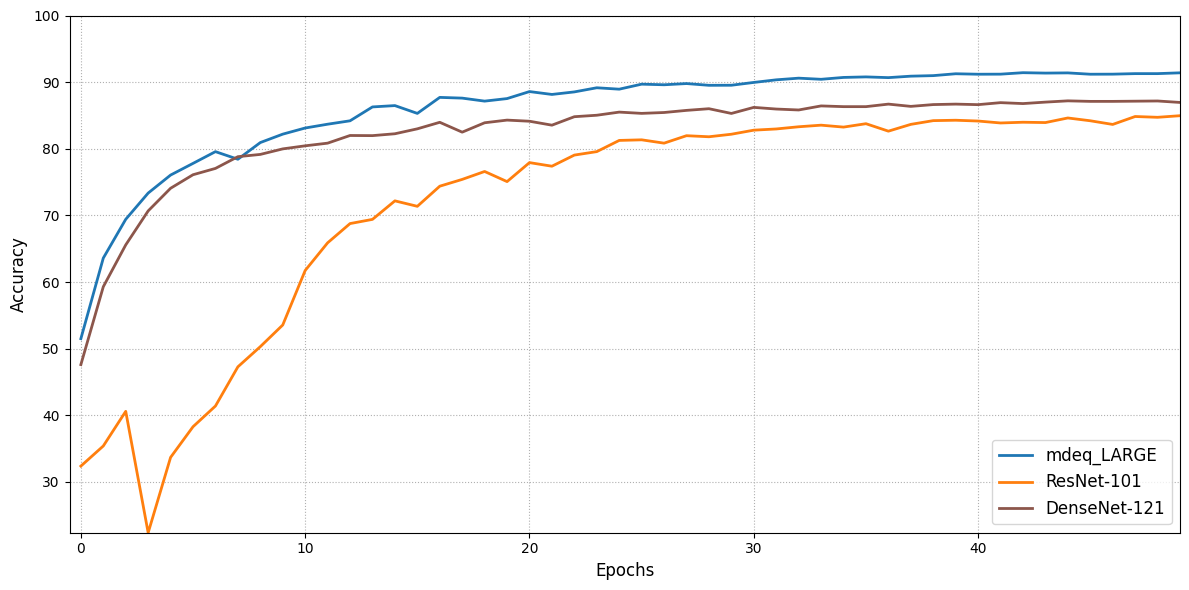

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(epochs1_test, accuracies1_test, label='mdeq_LARGE', linewidth=2, color='tab:blue')
plt.plot(epochs2_test, accuracies2_test, label='ResNet-101', linewidth=2, color='tab:orange')
plt.plot(epochs3_test, accuracies3_test, label='DenseNet-121', linewidth=2, color='tab:brown')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
#plt.title('Evolución de la precisión en test', fontsize=16)
plt.xlim(-0.5, max(max(epochs1_test), max(epochs2_test), max(epochs3_test)))
plt.ylim(min(min(accuracies1_test), min(accuracies2_test), min(accuracies3_test)), 100)
plt.legend(loc='lower right', fontsize=12)
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('figuras/segundo-precision-en-test.png')
plt.show()

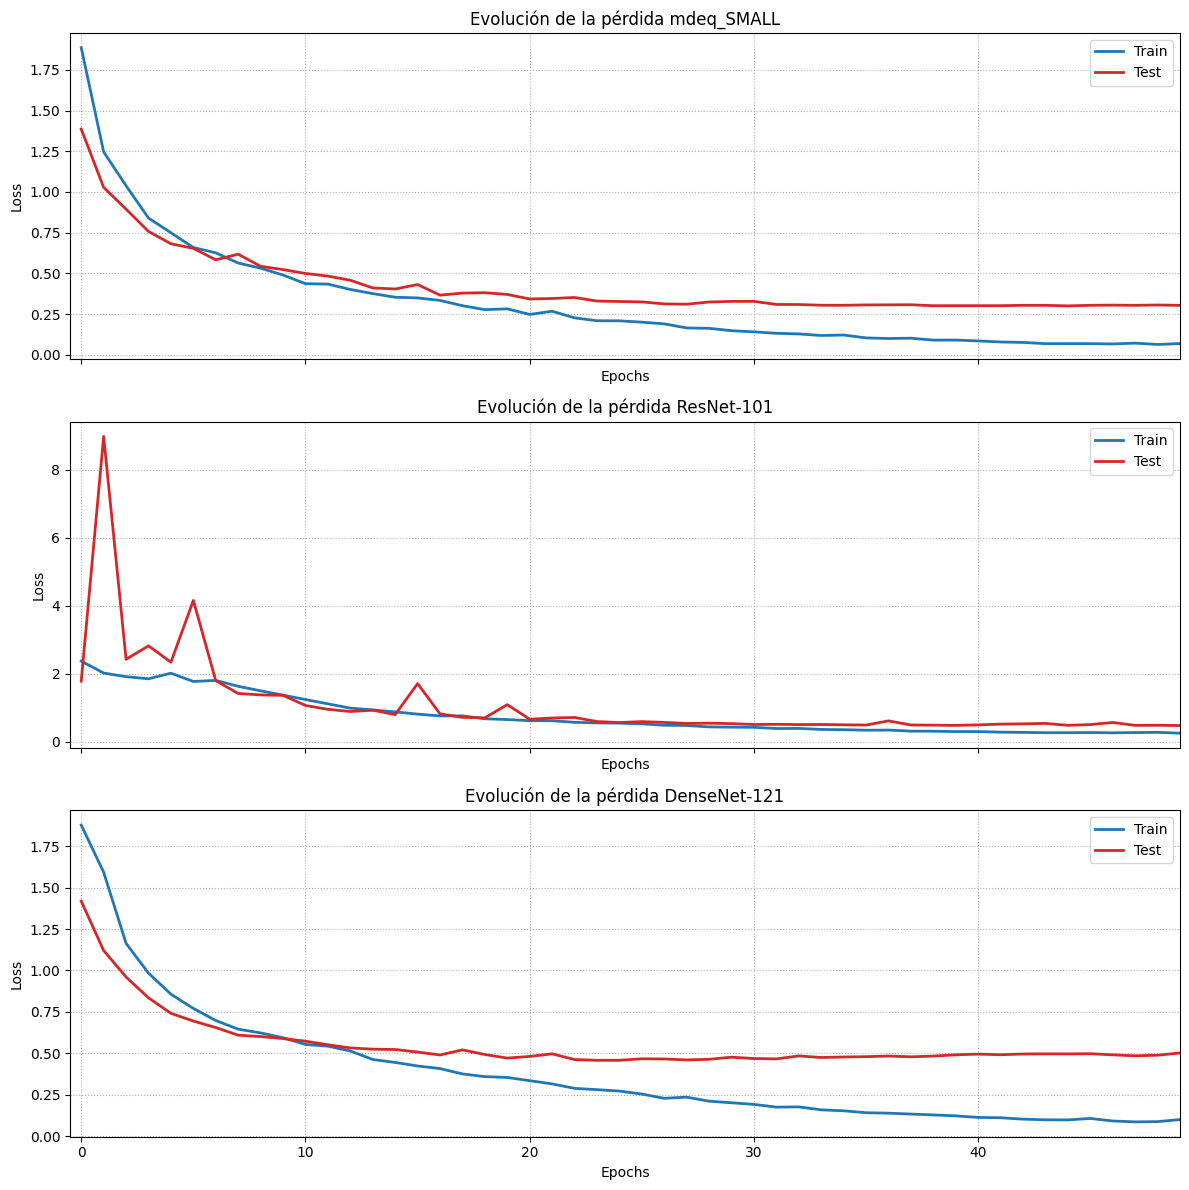

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

ax1.plot(epochs1_train, losses1_train, label='Train', linewidth=2, color='tab:blue')
ax1.plot(epochs1_test, losses1_test, label='Test', linewidth=2, color='tab:red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Evolución de la pérdida mdeq_SMALL')
ax1.grid(linestyle='dotted')
ax1.legend()

ax2.plot(epochs2_train, losses2_train, label='Train', linewidth=2, color='tab:blue')
ax2.plot(epochs2_test, losses2_test, label='Test', linewidth=2, color='tab:red')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Evolución de la pérdida ResNet-101')
ax2.grid(linestyle='dotted')
ax2.legend()

ax3.plot(epochs3_train, losses3_train, label='Train', linewidth=2, color='tab:blue')
ax3.plot(epochs3_test, losses3_test, label='Test', linewidth=2, color='tab:red')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.set_title('Evolución de la pérdida DenseNet-121')
ax3.grid(linestyle='dotted')
ax3.legend()

plt.xlim(-0.5, max(max(epochs1_train), max(epochs1_test)))
plt.tight_layout()

plt.show()

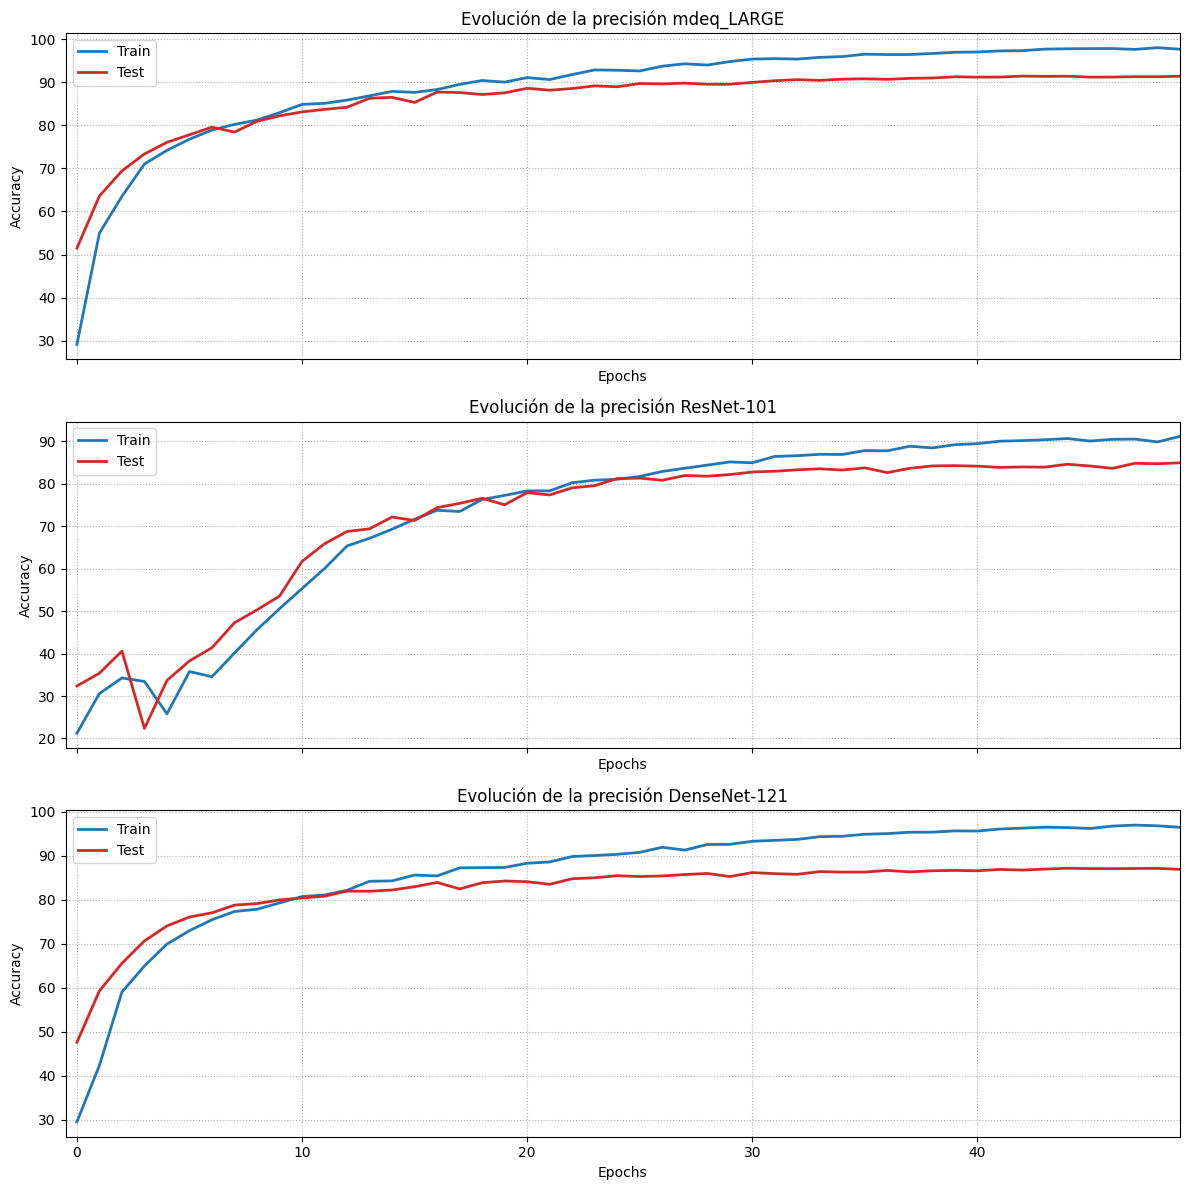

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

ax1.plot(epochs1_train, accuracies1_train, label='Train', linewidth=2, color='tab:blue')
ax1.plot(epochs1_test, accuracies1_test, label='Test', linewidth=2, color='tab:red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Evolución de la precisión mdeq_LARGE')
ax1.grid(linestyle='dotted')
ax1.legend()

ax2.plot(epochs2_train, accuracies2_train, label='Train', linewidth=2, color='tab:blue')
ax2.plot(epochs2_test, accuracies2_test, label='Test', linewidth=2, color='tab:red')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Evolución de la precisión ResNet-101')
ax2.grid(linestyle='dotted')
ax2.legend()

ax3.plot(epochs3_train, accuracies3_train, label='Train', linewidth=2, color='tab:blue')
ax3.plot(epochs3_test, accuracies3_test, label='Test', linewidth=2, color='tab:red')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Accuracy')
ax3.set_title('Evolución de la precisión DenseNet-121')
ax3.grid(linestyle='dotted')
ax3.legend()

plt.xlim(-0.5, max(max(epochs1_train), max(epochs1_test)))
plt.tight_layout()

plt.show()

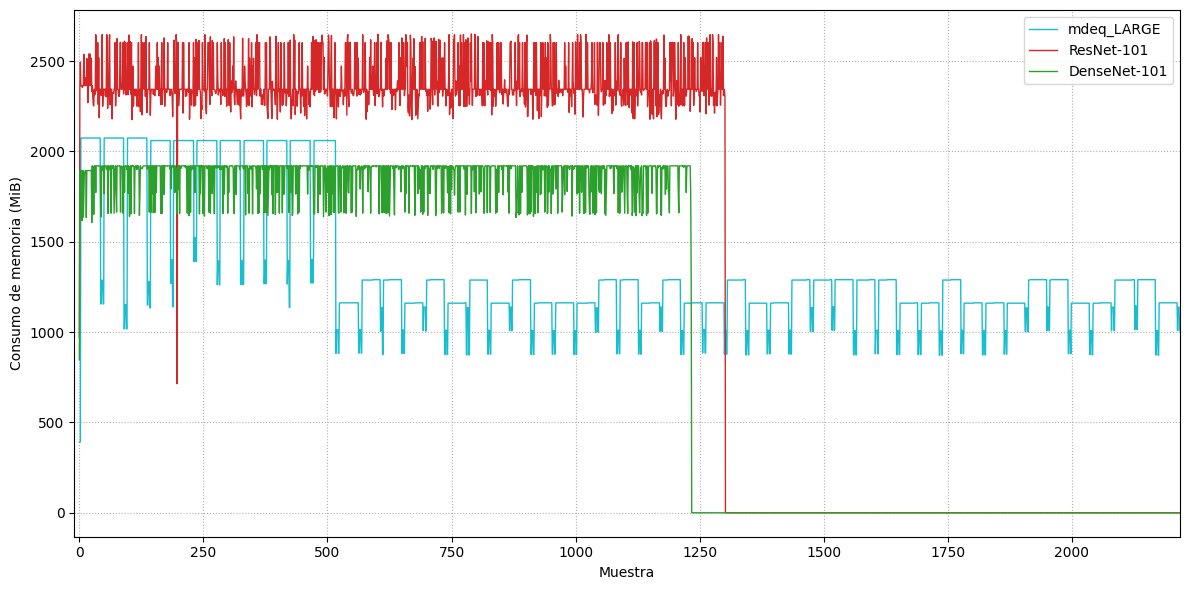

In [35]:
max_length = max(len(consumption1), len(consumption2), len(consumption3))
# como un proceso tarda mas que el otro, relleno con 0s
consumption1 = consumption1 + [0]*(max_length - len(consumption1))
consumption2 = consumption2 + [0]*(max_length - len(consumption2))
consumption3 = consumption3 + [0]*(max_length - len(consumption3))

plt.figure(figsize=(12, 6))
plt.plot(consumption1,  label='mdeq_LARGE', linewidth=1, color='tab:cyan')
plt.plot(consumption2, label='ResNet-101', linewidth=1, color='tab:red')
plt.plot(consumption3, label='DenseNet-101', linewidth=1, color='tab:green')
plt.xlabel('Muestra')
plt.ylabel('Consumo de memoria (MiB)')
plt.xlim(-10, max_length)
#plt.title('Evolución del consumo de memoria')
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.legend()

plt.savefig('figuras/segundo-gpu.png')

# Mostrar el gráfico
plt.show()
